<a href="https://colab.research.google.com/github/lazy-wav/Data-Analysis/blob/main/poli_on_gossipDataDistil.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving saved_model.zip to saved_model.zip


In [2]:
import zipfile

with zipfile.ZipFile("saved_model.zip", 'r') as zip_ref:
    zip_ref.extractall("saved_model")


In [3]:
from google.colab import files
uploaded = files.upload()


Saving gossipcop_real.csv to gossipcop_real.csv


In [4]:
uploaded = files.upload()

Saving gossipcop_fake.csv to gossipcop_fake.csv


In [5]:
import pandas as pd
import torch
from transformers import DistilBertTokenizerFast
from datasets import Dataset
from transformers import DistilBertForSequenceClassification

In [6]:
from tqdm import tqdm
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [7]:
tokenizer = DistilBertTokenizerFast.from_pretrained('./saved_model')
model = DistilBertForSequenceClassification.from_pretrained('./saved_model')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): DistilBertSdpaAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)


In [8]:
true_data = pd.read_csv('gossipcop_real.csv')
fake_data = pd.read_csv('gossipcop_fake.csv')

true_data['label'] = 0
fake_data['label'] = 1

data = pd.concat([true_data, fake_data]).reset_index(drop=True)
texts = data['title'].fillna("").astype(str).tolist()
labels = data['label'].tolist()

# Tokenize texts
encodings = tokenizer(texts, truncation=True, padding=True, max_length=64, return_tensors='pt')

In [9]:
from datasets import load_metric

In [10]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

all_preds = np.empty(0, dtype=int)
all_labels = np.empty(0, dtype=int)

batch_size = 8
correct = 0
total = 0

for i in tqdm(range(0, len(texts), batch_size)):
    batch_texts = texts[i:i+batch_size]
    batch_labels = labels[i:i+batch_size]

    encodings = tokenizer(batch_texts, truncation=True, padding=True, max_length=64, return_tensors='pt')
    input_ids = encodings['input_ids'].to(device)
    attention_mask = encodings['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        preds = torch.argmax(outputs.logits, dim=-1).cpu().numpy()
    all_preds = np.concatenate((all_preds, preds))
    all_labels = np.concatenate((all_labels, batch_labels))


100%|██████████| 2768/2768 [19:02<00:00,  2.42it/s]



 Accuracy: 0.38708220415537486

 Classification Report (Precision, Recall, F1-score, Support):

              precision  recall  f1-score    support
Real              0.803   0.256     0.388  16817.000
Fake              0.254   0.802     0.386   5323.000
accuracy          0.387   0.387     0.387      0.387
macro avg         0.529   0.529     0.387  22140.000
weighted avg      0.671   0.387     0.388  22140.000

 Confusion Matrix:
 [[ 4301 12516]
 [ 1054  4269]]


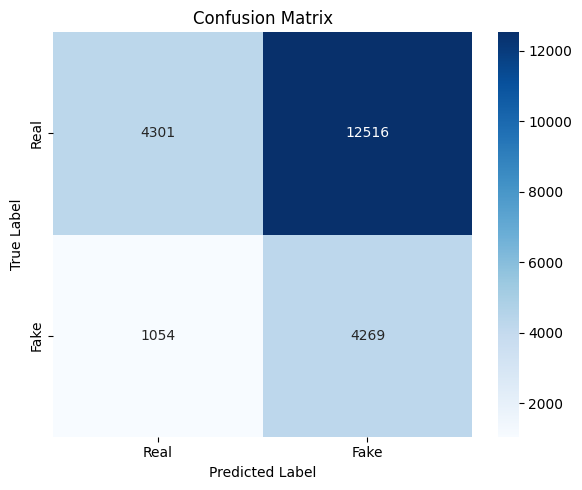

In [11]:
print("\n Accuracy:", accuracy_score(all_labels, all_preds))

report = classification_report(all_labels, all_preds, target_names=["Real", "Fake"], output_dict=True)
df_report = pd.DataFrame(report).transpose()

print("\n Classification Report (Precision, Recall, F1-score, Support):\n")
print(df_report.round(3))

# Step 7: Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
print("\n Confusion Matrix:\n", cm)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Real", "Fake"], yticklabels=["Real", "Fake"])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()